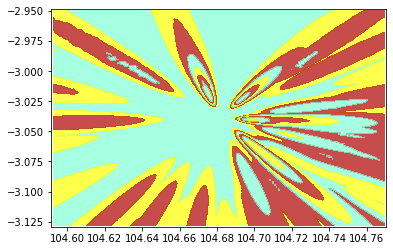

In [1]:
import numpy as np
import pandas as pd
import folium
import branca
import branca.colormap as cm
from folium import plugins
from folium.plugins import HeatMap
from pyproj import Proj
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

file = "D:\TRUSUR\Data Analytics\Air Dispersion Modeling\Palembang Dispersion\AERMOD\CO\Hujan\PLT24ALLCOHUJAN.PLT"

# Load dataset
df = pd.read_csv(file, header=None, delim_whitespace=True, skiprows=8, 
                 names=["X", "Y", "C", "Zelev", "Zhill", "Zflag", "Avg", "Grp", "Years", "ID", "Date"])

# Converting UTM to Datum
myProj = Proj("+proj=utm +zone=48 +south +datum=WGS84 +units=m +no_defs")
lon, lat = myProj(df["X"].to_numpy(), df["Y"].to_numpy(), inverse=True)

# Create map_df
df['lat'] = lat
df['lon'] = lon
map_df = df[['lat', 'lon', 'C']]

# Setup the folium map
map = folium.Map(location=[map_df['lat'].mean(), map_df['lon'].mean()],
                 zoom_start=12.5,
                 tiles="OpenStreetMap")

# 1. Create Ispoleth
# Make original data
x_orig = np.asarray(map_df.lon.tolist())
y_orig = np.asarray(map_df.lat.tolist())
z_orig = np.asarray(map_df.C.tolist())

# Make a grid
x_arr = np.linspace(np.min(x_orig), np.max(x_orig), 200)
y_arr = np.linspace(np.min(y_orig), np.max(y_orig), 200)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

# Gaussian filter the grid to make it smoother
# sigma = [5,5]
# z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

# Setup colormap
colors = ['aquamarine', 'yellow', '#b00202']
vmin   = np.min(map_df.C)
vmax   = np.max(map_df.C)
vcen   = vmax / 2
cmap   = cm.LinearColormap(colors,
                         index=[vmin, vcen, vmax],
                         vmin=vmin,
                         vmax=vmax,
                         caption='Concentration ('  +'\u03BC' +'g/m\u00b3' +')')

# Create contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, 
                        alpha=0.7, colors=colors,
                        linestyles='None', vmin=vmin, vmax=vmax)

# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(contourf=contourf,
                                             min_angle_deg=3.0,
                                             ndigits=5,
                                             stroke_width=1,
                                             fill_opacity=0.5)

# Plot contour on the folium map
folium.GeoJson(geojson, 
               style_function=lambda x: {
                   'color' : x['properties']['stroke'],
                   'weight': x['properties']['stroke-width'],
                   'fillColor' : x['properties']['fill'],
                   'opacity' : 0.7}
              ).add_to(folium.FeatureGroup(name="Isopleth").add_to(map))

# 2. Create Heatmap
HeatMap(map_df,
        min_opacity=0.0000000000001,
        blur=20).add_to(folium.FeatureGroup(name="Heatmap").add_to(map))

# 3. Pola Sebaran
# for i in range(len(map_df)):
#     folium.Circle(
#         location=[map_df.iloc[i]['lat'], map_df.iloc[i]['lon']],
#         opacity=0.6,
#         radius=10,
#         fill=True,
#         color=cmap(map_df.iloc[i]['C'])
#     ).add_to(folium.FeatureGroup(name="Pola Sebaran").add_to(map))

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(map)
    
# Add layer control & colormap
folium.LayerControl().add_to(map)
map.add_child(cmap)

#Display the map
map